In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import torch
from covapt_mt.covapt import covariance_model
from covapt_mt.utils import load_config_file
import itertools

In [2]:
config_dict = load_config_file("config/covariance_emulator.yaml")

k_data = np.load(config_dict["input_dir"] + config_dict["k_array_file"])
k_0 = k_data["k_0"]
print(config_dict["output_dir"] + config_dict["covariance_file"])
C_data = np.load(config_dict["output_dir"] + config_dict["covariance_file"])#+ config_dict["covariance_file"])
C_G, P_G = [], []
num_zbins = len(C_data.files)
num_tracers = config_dict["num_tracers"]
num_spectra = int(num_tracers*(num_tracers+1)/2)
num_kbins = len(k_0)
num_ells = 2

print(k_0, len(k_0))

for z in range(num_zbins):
    C_G.append(C_data["zbin_"+str(z)])
    P_G.append(np.linalg.inv(C_G[z]))

/home/joeadamo/Research/SPHEREx/covapt_mt/data/output_data/cov_2_tracer_2_redshift.npz
[0.00792 0.01576 0.0236  0.03144 0.03928 0.04712 0.05496 0.0628  0.07064
 0.07848 0.08632 0.09416 0.102   0.10984 0.11768 0.12552 0.13336 0.1412
 0.14904 0.15688 0.16472 0.17256 0.1804  0.18824 0.19608] 25


In [25]:
def CorMat(cov):
    rms = np.sqrt(np.diag(cov))
    cor = np.copy(cov)
    for i in range(cov.shape[0]):
        for j in range(cov.shape[0]):
            cor[i,j] = cov[i,j]/(rms[i]*rms[j])
    return cor

ERROR! Covariance matrix is not positive definite!
ERROR! Correlation matrix is not positive definite!
0.0 1029186047.8624564
Covariance matrix is positive definite! :)
Correlation matrix is positive definite! :)
0.0 1277163512.9841852


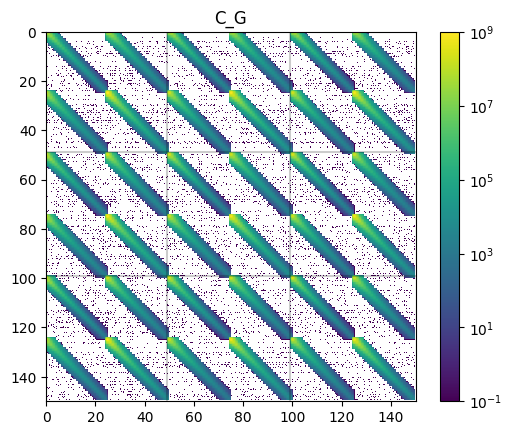

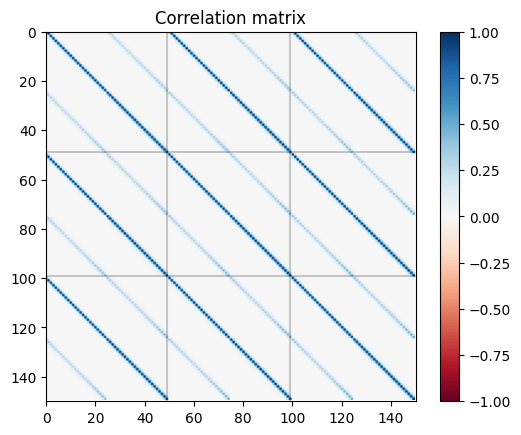

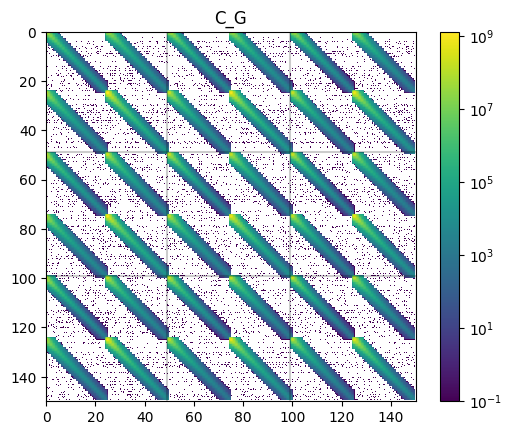

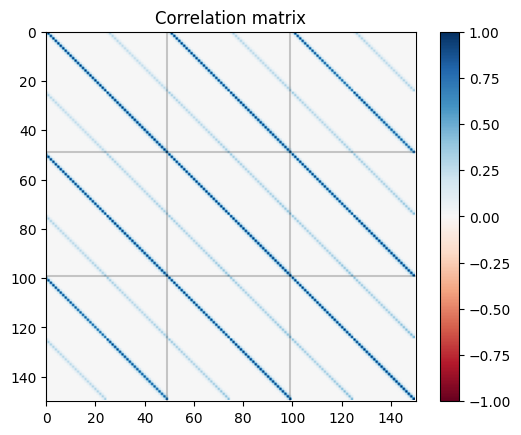

In [28]:
for z in range(num_zbins):

    # idx = np.where(C_G[z] < 1e10)
    # print(idx)
    # C_G[z][idx] = 0
    #C_G[z][(C_G[z] < 10)] = 0
    corr = CorMat(C_G[z])
    
    try:
        L = np.linalg.cholesky(C_G[z])
        print("Covariance matrix is positive definite! :)")
    except:
        print("ERROR! Covariance matrix is not positive definite!")

    try:
        L = np.linalg.cholesky(corr)
        print("Correlation matrix is positive definite! :)")
    except:
        print("ERROR! Correlation matrix is not positive definite!")
    
    print(np.amin(C_G[z]), np.amax(C_G[z]))
    plt.figure()
    plt.title("C_G")
    img = plt.imshow(C_G[z], cmap="viridis",  norm=colors.LogNorm(vmin=0.1, vmax=np.amax(C_G[z])))
    #img = plt.imshow(C_G[z], cmap="RdBu",  norm=colors.SymLogNorm(linthresh=1., vmin=np.amin(C_G[z]), vmax=np.amax(C_G[z])))
    for i in range(num_spectra):
        plt.axvline(i*num_kbins*num_ells - 1, c="black", alpha=0.2)
        plt.axhline(i*num_kbins*num_ells - 1, c="black", alpha=0.2)
    plt.xlim(0, num_spectra*num_ells*num_kbins)
    plt.ylim(num_spectra*num_ells*num_kbins, 0)
    plt.colorbar()
    
    plt.figure()
    plt.title("Correlation matrix")
    img = plt.imshow(corr, vmin=-1, vmax=1, cmap="RdBu")
    for i in range(num_spectra):
        plt.axvline(i*num_kbins*num_ells - 1, c="black", alpha=0.2)
        plt.axhline(i*num_kbins*num_ells - 1, c="black", alpha=0.2)
    plt.xlim(0, num_spectra*num_ells*num_kbins)
    plt.ylim(num_spectra*num_ells*num_kbins, 0)
    plt.colorbar()

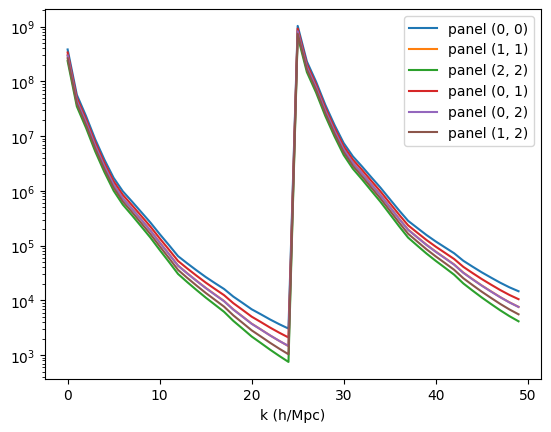

In [6]:
plt.plot(np.diag(C_G[0])[:2*num_kbins], label="panel (0, 0)")
plt.plot(np.diag(C_G[0])[2*num_kbins:4*num_kbins], label="panel (1, 1)")
plt.plot(np.diag(C_G[0])[4*num_kbins:6*num_kbins], label="panel (2, 2)")
plt.plot(np.diag(C_G[0][:2*num_kbins, 2*num_kbins:4*num_kbins]), label="panel (0, 1)")
plt.plot(np.diag(C_G[0][:2*num_kbins, 4*num_kbins:6*num_kbins]), label="panel (0, 2)")
plt.plot(np.diag(C_G[0][2*num_kbins:4*num_kbins, 4*num_kbins:6*num_kbins]), label="panel (1, 2)")
#plt.plot(np.diag(C_G[0])[num_kbins:], label="(2, 2) diagonal")
#plt.xscale("log")
plt.yscale("log")

plt.xlabel("k (h/Mpc)")
plt.legend()

there are 27 negative eigenvalues!
there are 0 eigenvalues equal to 0!
there are 0 negative eigenvalues!
there are 0 eigenvalues equal to 0!


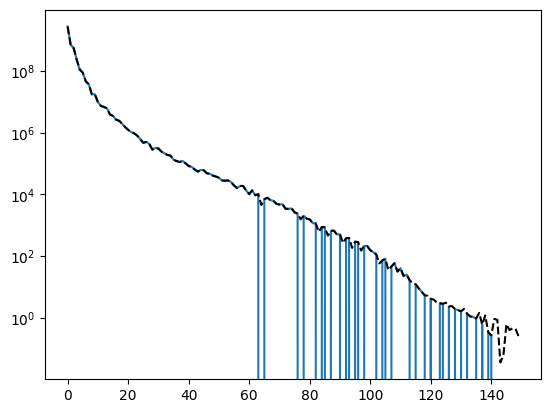

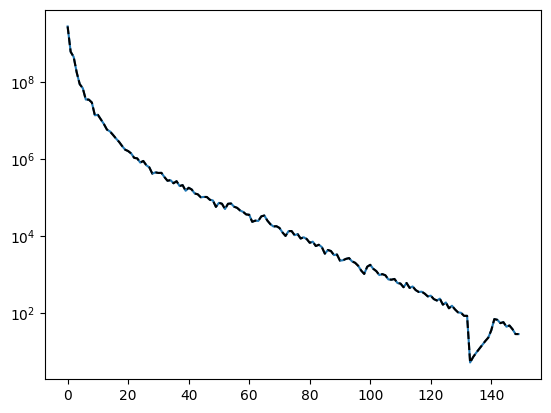

In [29]:
for z in range(num_zbins):
    eigvals_true, __ = np.linalg.eig(C_G[z])
    
    print("there are {:0.0f} negative eigenvalues!".format(len(eigvals_true[(eigvals_true < 0)])))
    print("there are {:0.0f} eigenvalues equal to 0!".format(len(eigvals_true[(eigvals_true == 0)])))
    plt.figure()
    plt.plot(eigvals_true)
    plt.plot(abs(eigvals_true), c="black", ls="--")
    plt.yscale("log")

'Fixed' Covariance matrix is positive definite! :)
there are 0 negative eigenvalues!
'Fixed' Covariance matrix is positive definite! :)
there are 0 negative eigenvalues!


/tmp/ipykernel_711953/3430871518.py:28: RuntimeWarning: divide by zero encountered in divide
  plt.imshow(100*(C_fixed - C_G[z]) / C_G[z], cmap="RdBu")
/tmp/ipykernel_711953/3430871518.py:28: RuntimeWarning: invalid value encountered in divide
  plt.imshow(100*(C_fixed - C_G[z]) / C_G[z], cmap="RdBu")


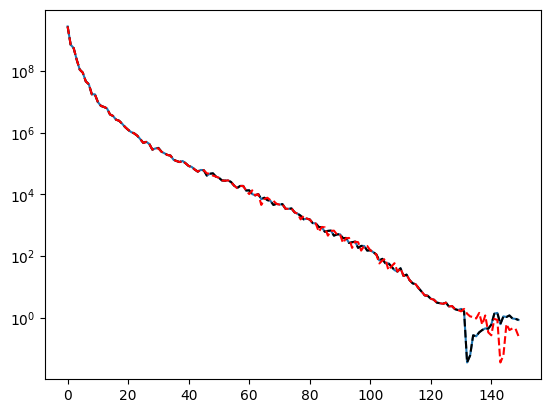

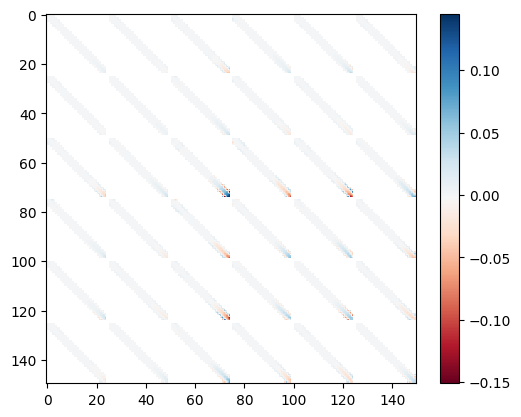

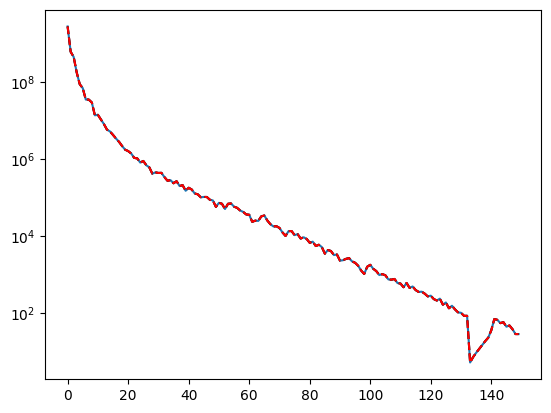

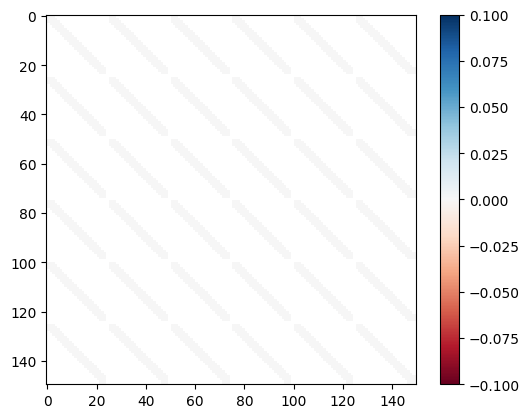

In [31]:
# TEMP FIX: manually set eigenvalues to positive
# DO THIS AT YOUR OWN PERIL!
C_G_fixed = []
for z in range(num_zbins):
    eigvals_true, Q = np.linalg.eig(C_G[z])
    if np.any(eigvals_true < 0):
        C_fixed = Q @ (np.diag(abs(eigvals_true)) @ np.linalg.inv(Q))
    else:
        C_fixed = C_G[z]
        
    try:
        L = np.linalg.cholesky(C_fixed)
        L = np.linalg.cholesky(np.linalg.inv(C_fixed))
        print("'Fixed' Covariance matrix is positive definite! :)")
    except:
        print("ERROR! 'Fixed' Covariance matrix is not positive definite!")
    
    C_G_fixed.append(C_fixed)
    eigvals, Q = np.linalg.eig(C_fixed)
    print("there are {:0.0f} negative eigenvalues!".format(len(eigvals[(eigvals < 0)])))
    plt.figure()
    plt.plot(eigvals)
    plt.plot(abs(eigvals), c="black", ls="--")
    plt.plot(abs(eigvals_true), c="red", ls="--")
    plt.yscale("log")
    
    plt.figure()
    plt.imshow(100*(C_fixed - C_G[z]) / C_G[z], cmap="RdBu")
    plt.colorbar()
    # plt.plot(np.diag(C_G[0]), label="raw matrix")
    # plt.plot(np.diag(C_fixed), ls="--", label="fixed matrix")
    # plt.yscale("log")
    # plt.legend()

In [19]:
def check_leading_principle_minors(cov):
    """A leading principle minora is defined as the determinant of a submatrix with the last n rows / columns
    removed. For a positive-definite block matrix, all leading principle minors should be positive"""
    negative_minors = 0
    n = cov.shape[0]
    for k in range(1, cov.shape[0]):
        cov_sub = cov[:n-k, :n-k]
        det_sign, det = np.linalg.slogdet(cov_sub)
        if det_sign == -1:
            print("k = {:0.0f} has a negative principle minor!".format(k))
            negative_minors += 1
    if negative_minors == 0: print("All leading principle minors are positive")

In [20]:
# check if subsets of the covariance matrix are positive-definite
for z in range(num_zbins):

    check_leading_principle_minors(C_G[z])
    det_sign, det = np.linalg.slogdet(C_G[z])
    print("Log determinant = {:0.3e}".format(det * det_sign))
    
    for i in range(num_spectra):
        for j in range(num_spectra):
            C_sub = C_G[z][i*2*num_kbins: (i+1)*2*num_kbins,j*2*num_kbins: (j+1)*2*num_kbins]
            #check_leading_principle_minors(C_sub)
            det_sign, det = np.linalg.slogdet(C_sub)
            print("sub log determinant = {:0.3e}".format(det * det_sign))
            try:
                L = np.linalg.cholesky(C_sub)
                print("Partial covariance matrix ({:0.0f}, {:0.0f}) is positive-definite :)".format(i, j))
            except:
                print("Partial covariance matrix ({:0.0f}, {:0.0f}) is NOT positive-definite".format(i, j))
        #print(i*2*num_kbins, j*2*num_kbins)
        #C_sub = C_G[0][

# plt.imshow(CorMat(C_sub), cmap="RdBu", vmin=-1, vmax=1)
# plt.colorbar()

k = 2 has a negative principle minor!
k = 4 has a negative principle minor!
k = 6 has a negative principle minor!
k = 7 has a negative principle minor!
k = 9 has a negative principle minor!
k = 10 has a negative principle minor!
k = 11 has a negative principle minor!
k = 12 has a negative principle minor!
k = 13 has a negative principle minor!
k = 14 has a negative principle minor!
k = 15 has a negative principle minor!
k = 16 has a negative principle minor!
k = 20 has a negative principle minor!
k = 22 has a negative principle minor!
k = 24 has a negative principle minor!
k = 26 has a negative principle minor!
k = 28 has a negative principle minor!
k = 30 has a negative principle minor!
k = 32 has a negative principle minor!
k = 33 has a negative principle minor!
k = 34 has a negative principle minor!
k = 35 has a negative principle minor!
k = 36 has a negative principle minor!
k = 37 has a negative principle minor!
k = 38 has a negative principle minor!
k = 39 has a negative principl

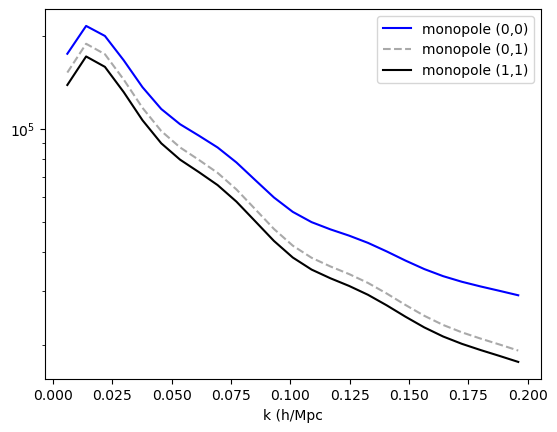

In [30]:
#pk = np.load("/home/joeadamo/Research/SPHEREx/spherex_emu/data/ps_fid.npy")
pk= np.load("/home/joeadamo/Research/SPHEREx/covapt_mt/data/input_data/ps_emu_test_2_tracers.npy")

# plt.plot(pk[0,0,0,:], label="idx 0")
# plt.plot(pk_2[0,0,0,:], ls="--", label="idx 0 2")
# plt.plot(pk[0,0,1,:], label="idx 1")
# plt.plot(pk_2[0,0,1,:], ls="--", label="idx 1 2")
# plt.legend()
# plt.yscale("log")

plt.figure()
plt.plot(k_0, pk[0,0,0,:], c="blue", label="monopole (0,0)")
#plt.plot(pk[0,3,0,:], c="red",label="monopole (1,1)")
#plt.plot(pk[0,5,0,:], c="green",label="monopole (2,2)")
#plt.axhline(1. / 0.00282, c="red", ls="--")
plt.plot(k_0, pk[0,1,0,:], c="darkgrey", ls="--", label="monopole (0,1)")
plt.plot(k_0, pk[0,2,0,:], c="black", label="monopole (1,1)")
#plt.plot(pk[0,4,0,:], c="grey", ls="--", label="monopole (1,2)")
plt.legend()
plt.xlabel("k (h/Mpc")
plt.yscale("log")

In [26]:
# Save the k array
#k = np.array([0.00694, 0.01482, 0.0227, 0.03058, 0.03846, 0.04634, 0.05422, 0.0621, 0.06998,
#              0.07786, 0.08574, 0.09362, 0.1015,  0.10938, 0.11726, 0.12514, 0.13302, 0.1409,
#              0.14878, 0.15666, 0.16454, 0.17242, 0.1803,  0.18818, 0.19606])
k = np.linspace(0.002, 0.2, 26)
k_centers = (k[:-1] + k[1:]) / 2
print(k_centers, len(k_centers))
np.savez("data/input_data/k_emu_test.npz", k_0=k_centers)

[0.00596 0.01388 0.0218  0.02972 0.03764 0.04556 0.05348 0.0614  0.06932
 0.07724 0.08516 0.09308 0.101   0.10892 0.11684 0.12476 0.13268 0.1406
 0.14852 0.15644 0.16436 0.17228 0.1802  0.18812 0.19604] 25


In [10]:
def flip_axes(cov, nps, nk, nl):
    """flip nk and nl dimensions"""
    new_cov = []
    for z in range(len(cov)):
        new_cov.append(np.zeros_like(cov[z]))
        print(new_cov[z].shape)
        tmp_cov = cov[z].reshape(nps, nl, nk, nps, nl, nk)
        tmp_cov = tmp_cov.transpose(0, 2, 1, 3, 5, 4)
        new_cov[z] = tmp_cov.reshape(nps*nk*nl, nps*nk*nl)
        print(tmp_cov.shape)
        
        # for ips in range(nps):
        #     for ik in range(nk):
        #         for il in range(nl):
        #             for jps in range(nps):
        #                 for jk in range(nk):
        #                     for jl in range(nl):
        #                         I = il + ik*nl + ips*nk*nl
        #                         J = jl + jk*nl + jps*nk*nl
        #                         new_cov[z][I,J] = cov[z][J,I]
    return new_cov

In [18]:
cov_reshape = flip_axes(C_G, num_spectra, num_kbins, num_ells)
np.save(config_dict["output_dir"]+"invcov_with_hexadecapole.npy", np.linalg.inv(cov_reshape[0]))

cov_reshape = flip_axes(C_G_fixed, num_spectra, num_kbins, num_ells)
np.save(config_dict["output_dir"]+"invcov_with_hexadecapole_regularized.npy", np.linalg.inv(cov_reshape[0]))

(192, 192)
(1, 64, 3, 1, 64, 3)
(192, 192)
(1, 64, 3, 1, 64, 3)


(150, 150)
(3, 25, 2, 3, 25, 2)
(150, 150)
(3, 25, 2, 3, 25, 2)
[]


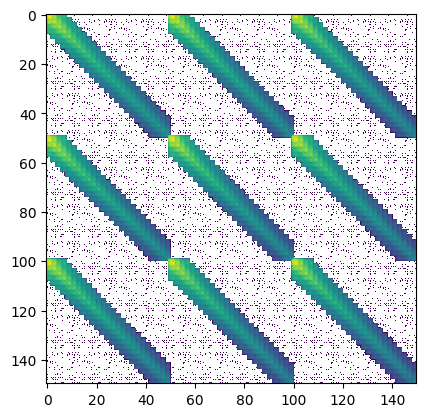

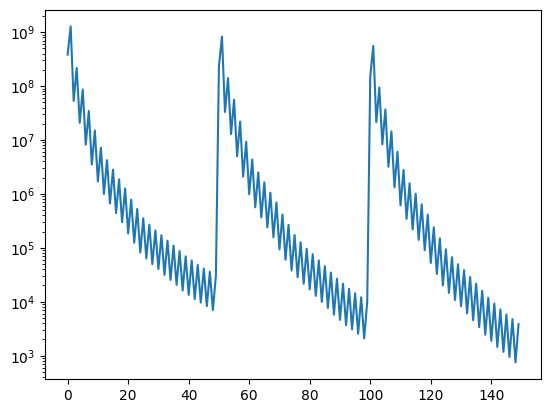

In [10]:
new_cov = flip_axes(C_G_fixed, num_spectra, num_kbins, num_ells)
eig, q = np.linalg.eigh(np.linalg.inv(new_cov[0]))
print(eig[(eig < 0)])

img = plt.imshow(new_cov[1], cmap="viridis",  norm=colors.LogNorm(vmin=0.1, vmax=np.amax(C_G[z])))

plt.figure()
plt.plot(np.diag(new_cov[z]))
plt.yscale("log")

(150, 150)
(3, 25, 2, 3, 25, 2)
(150, 150)
(3, 25, 2, 3, 25, 2)
ERROR!, matrix [0, 0, 1] is not positive-definite!
ERROR!, matrix [1, 0, 1] is not positive-definite!


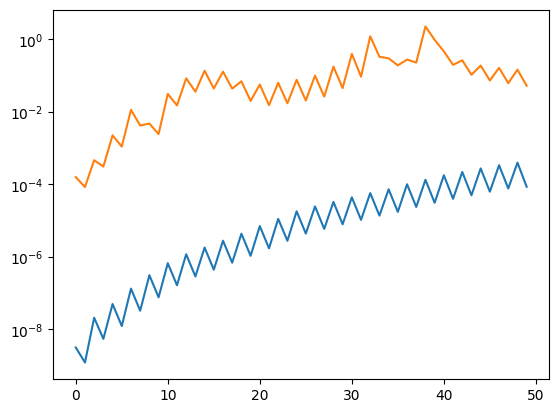

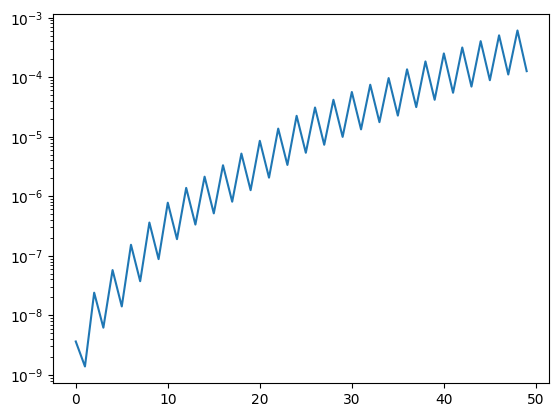

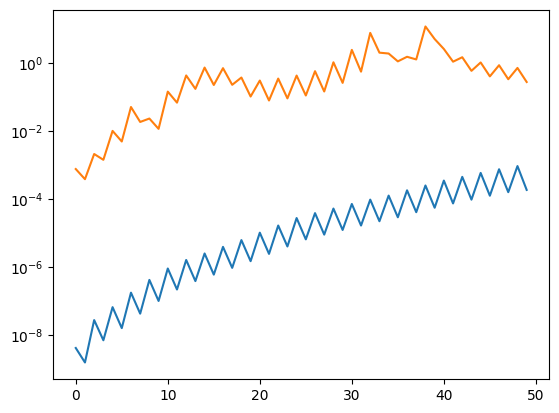

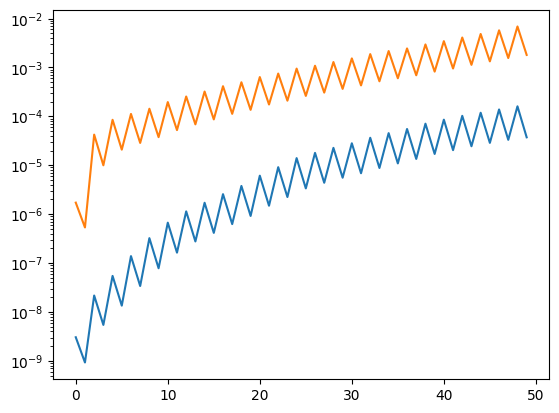

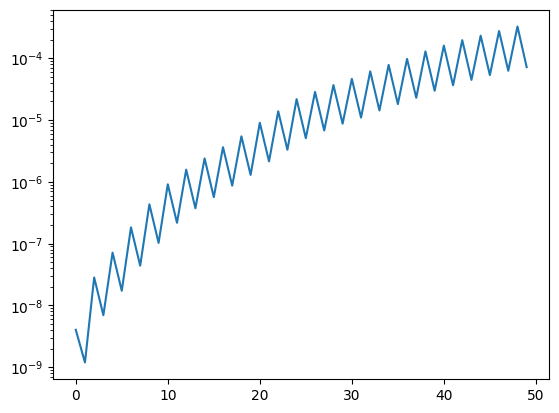

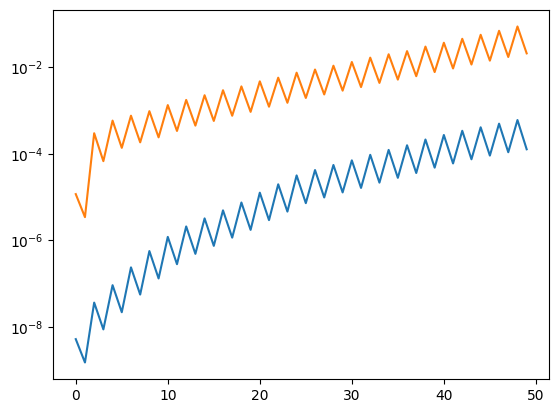

In [33]:
# # save inverse matrices as a dictionary of pytorch tensors
# # NOTE: You should do this calculation in double percision to increase numerical stability
# P = {}
# P = torch.zeros((num_zbins, new_cov[0].shape[0], new_cov[0].shape[1]), dtype=torch.float64)
# for z in range(num_zbins):
#     bin_str = "zbin_"+str(z)
#     print(bin_str)
#     L = np.linalg.cholesky(new_cov[z])
#     P[z] = torch.from_numpy(np.linalg.inv(new_cov[z]))

#     eig, q = torch.linalg.eigh(P[z])
#     print((eig[(eig < 0)]))
#     assert torch.all(eig > 0)
    
# print(config_dict["output_dir"])
# print(P.shape, P.dtype)
# torch.save(P, config_dict["output_dir"]+"invcov.dat")

new_cov = flip_axes(C_G_fixed, num_spectra, num_kbins, num_ells)
P_full = np.zeros((num_zbins, num_spectra*num_kbins*num_ells, num_spectra*num_kbins*num_ells))
for z in range(num_zbins):
    P_full[z] = np.linalg.inv(new_cov[z])
    try:
        L = np.linalg.cholesky(P_full[z])
    except:
        print("ERROR!, matrix [{:d}] is not positive-definite!".format(z))

# Save a single panel for testing emulator with one tracer / redshift bin
# TODO: move to dedicated script
P_seperate = np.zeros((num_spectra, num_zbins, num_ells*num_kbins, num_ells*num_kbins))
P_seperate_2 = np.zeros((num_spectra, num_zbins, num_ells*num_kbins, num_ells*num_kbins))

for z in range(num_zbins):
    ps_idx = 0
    for ps_1, ps_2 in itertools.product(range(2), repeat=2):
        if ps_1 > ps_2: continue
        C_sub = new_cov[z][ps_1*num_ells*num_kbins: (ps_1+1)*num_ells*num_kbins,\
                           ps_2*num_ells*num_kbins: (ps_2+1)*num_ells*num_kbins]
        P_seperate[ps_idx, z] = np.linalg.inv(C_sub)
        P_seperate_2[ps_idx, z] = P_full[z][ps_1*num_ells*num_kbins: (ps_1+1)*num_ells*num_kbins,\
                                          ps_2*num_ells*num_kbins: (ps_2+1)*num_ells*num_kbins]
        
        plt.figure()
        plt.plot(np.diag(P_seperate[ps_idx, z]))
        plt.plot(np.diag(P_seperate_2[ps_idx, z]))
        plt.yscale("log")
        try:
            L = np.linalg.cholesky(P_seperate_2[ps_idx, z])
        except:
            print("ERROR!, matrix [{:d}, {:d}, {:d}] is not positive-definite!".format(z, ps_1, ps_2))
        #     eigvals_true, Q = np.linalg.eig(P_seperate[ps_idx, z])
        #     if np.any(eigvals_true < 0):
        #         P_fixed = Q @ (np.diag(abs(eigvals_true)) @ np.linalg.inv(Q))
        #         plt.figure()
        #         plt.imshow((P_fixed - P_seperate[ps_idx, z]) / P_seperate[ps_idx, z], cmap="RdBu", vmin=-1, vmax=1)
        #         plt.colorbar()
        ps_idx += 1
        
#C_small = new_cov[0][:50, :50]
#img = plt.imshow(C_small, cmap="viridis",  norm=colors.LogNorm(vmin=0.1, vmax=np.amax(C_G[z])))
#P_small = np.linalg.inv(C_small)
save_dir = "/home/joeadamo/Research/Data/SPHEREx-Data/Training-Set-EFT-2s-2z/"
#torch.save(torch.from_numpy(P_seperate), save_dir+"invcov.dat")
#torch.save(torch.from_numpy(P_full), save_dir+"invcov_full.dat")

Text(0, 0.5, 'diagonal covariance')

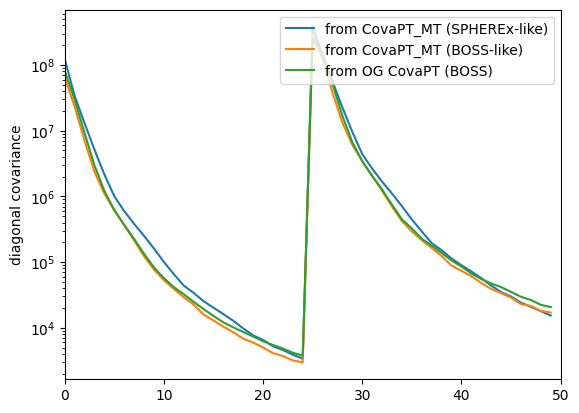

In [18]:
#old_cov_file = "/home/joeadamo/Research/Data/SPHEREx-Data/invcov.npy"
#old_cov = np.load(old_cov_file)
covnet_cov_file = np.load("/home/joeadamo/Research/Data/CovNet-Data/Cov_Fid.npz")
covnet_cov = covnet_cov_file["C_G"]

boss_cov_file = np.load("/home/joeadamo/Research/SPHEREx/covapt_mt/data/output_data/cov_boss.npz")
boss_cov = boss_cov_file["zbin_0"]
#plt.imshow(CorMat(old_cov[0]), cmap="RdBu", vmin=-1, vmax=1)

plt.figure()
#plt.plot(np.diag(np.linalg.inv(old_cov[0])), label="from Cosmo_Inference")
plt.plot(np.diag(C_G[0]), label="from CovaPT_MT (SPHEREx-like)")
plt.plot(np.diag(boss_cov), label="from CovaPT_MT (BOSS-like)")
plt.plot(np.diag(covnet_cov), label="from OG CovaPT (BOSS)")
plt.yscale("log")
plt.legend()
plt.xlim(0, 50)
plt.ylabel("diagonal covariance")

# plt.figure()
# plt.plot(np.diag(boss_cov) / np.diag(covnet_cov))
# plt.yscale("log")

(1, 1, 2, 25)


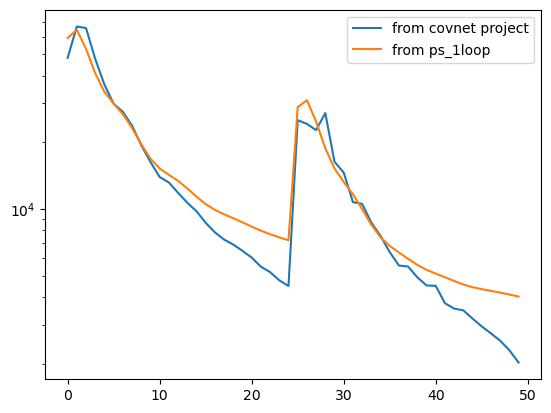

In [82]:
ps_covnet = np.load("/home/joeadamo/Research/Data/CovNet-Data/pk_ngc_z3_noisy.npz")
ps_covnet = ps_covnet["pk_noisy"][0]
ps_boss = np.load("/home/joeadamo/Research/SPHEREx/covapt_mt/data/input_data/ps_boss.npy")
print(ps_boss.shape)

plt.plot(ps_covnet, label="from covnet project")
plt.plot(ps_boss.flatten(), label="from ps_1loop")
plt.legend()
plt.yscale("log")

(25, 7, 15, 6) (25, 7, 15, 6)


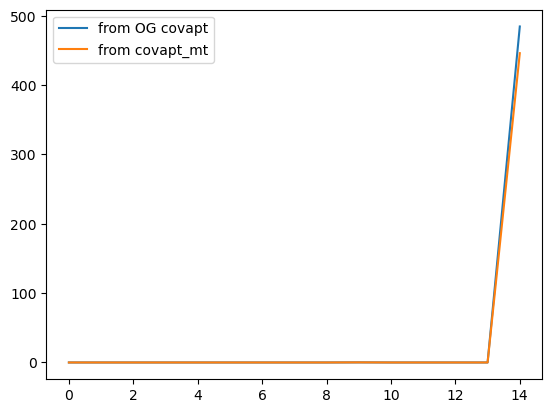

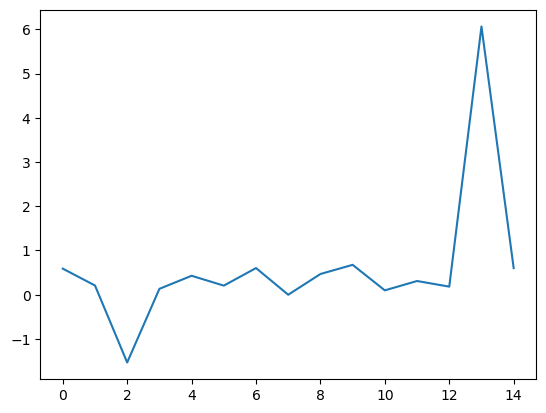

In [95]:
old_window = "/home/joeadamo/Documents/Research/CovaPT/Data/Wij_k25_HighZ_NGC.npy"
new_window = "/home/joeadamo/Research/SPHEREx/covapt_mt/data/output_data/Wij_boss_0.npy"

Wij_covnet = np.load(old_window)
Wij_new = np.load(new_window)

print(Wij_covnet.shape, Wij_new.shape)

plt.plot(Wij_covnet[10, 4, :, 0], label="from OG covapt")
plt.plot(Wij_new[10, 4, :, 0], label="from covapt_mt")
plt.legend()

plt.figure()
plt.plot(Wij_new[10, 5, :, 0] / Wij_covnet[10, 5, :, 0])

In [4]:
L = 4000 # NOTE: in Mpc/h 
m = 7    # NOTE: integer number of points per bin
k_max_cut = 0.25 # NOTE: integer number of points per bin
k_f = 2.*np.pi/L # fundamental frequency in h/Mpc
k_min = 0.5 * k_f 
k_bin_size = m * k_f 
N_bin = int(np.ceil((k_max_cut-k_min) / (k_bin_size))) 
k_max = k_min + N_bin * k_bin_size
N_edges = N_bin + 1

k_edges = np.linspace(k_min, k_max, N_edges) 
N_bin = N_bin
k_centers = 0.5 * (k_edges[:-1] + k_edges[1:])
np.savez("/home/joeadamo/Research/SPHEREx/covapt_mt/data/input_data/m2e/kbins.npz", k=k_centers)
print(N_bin)

k_edges_ref = np.array([0.0007854 , 0.01178097, 0.02277655, 0.03377212, 0.0447677 ,
       0.05576327, 0.06675884, 0.07775442, 0.08874999, 0.09974557,
       0.11074114, 0.12173672, 0.13273229, 0.14372786, 0.15472344,
       0.16571901, 0.17671459, 0.18771016, 0.19870574, 0.20970131,
       0.22069688, 0.23169246, 0.24268803, 0.25368361])
k_centers_ref = np.array([0.00628319, 0.01727876, 0.02827433, 0.03926991, 0.05026548,
       0.06126106, 0.07225663, 0.08325221, 0.09424778, 0.10524335,
       0.11623893, 0.1272345 , 0.13823008, 0.14922565, 0.16022123,
       0.1712168 , 0.18221237, 0.19320795, 0.20420352, 0.2151991 ,
       0.22619467, 0.23719025, 0.24818582])

print(k_edges - k_edges_ref)
print(k_centers - k_centers_ref)

23
[-1.83660255e-09  2.45096173e-09 -3.26147400e-09  1.02609028e-09
 -4.68634544e-09 -3.98781161e-10  3.88878311e-09 -1.82365260e-09
  2.46391167e-09 -3.24852406e-09  1.03904023e-09 -4.67339550e-09
 -3.85831228e-10  3.90173305e-09 -1.81070264e-09  2.47686160e-09
 -3.23557411e-09  1.05199019e-09 -4.66044556e-09 -3.72881281e-10
  3.91468299e-09 -1.79775272e-09  2.48981155e-09 -3.22262417e-09]
[-4.69282041e-09 -4.05256138e-10  3.88230814e-09 -1.83012758e-09
  2.45743670e-09 -3.25499903e-09  1.03256526e-09 -4.67987046e-09
 -3.92306188e-10  3.89525809e-09 -1.81717764e-09  2.47038665e-09
 -3.24204910e-09  1.04551523e-09 -4.66692052e-09 -3.79356269e-10
  3.90820803e-09 -1.80422768e-09  2.48333656e-09 -3.22909913e-09
  1.05846515e-09 -4.65397060e-09 -3.66406294e-10]
